### Imports 

In [2]:
import numpy as np
import pandas as pd
import json
from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

## Loading data and setting up the data frames

In [5]:
data_dir = "./project_data/" # Specify your data path (Folder in which the files are placed)

In [6]:
# Loading the data as pandas DataFrame
test = pd.read_json(data_dir + "test.json")
train = pd.read_json(data_dir + 'train.json')
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [7]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (8000, 4)


,id,formula,atoms,hform
0,5154,Zr2BO2,"(Atom('Zr', [1.6878604657, 0.892285133, 8.1345...",-2.037877
1,984,Ni2S6,"(Atom('Ni', [1.1571403137, 0.934725185, 12.234...",-0.091020
2,1634,Cd4K2Cl6O6Te2,"(Atom('Cd', [2.7840261751, 5.6922402759, 26.71...",-1.109751
3,1872,Hf4H2N3O2,"(Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...",-1.609142
4,2977,Sc2Te2,"(Atom('Te', [0.0003850118, 0.0002469812, 7.461...",-0.854593


In [8]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (4000, 3)


,id,formula,atoms
0,8538,HfZrSTe2,"(Atom('S', [-1.0327079693, 4.2080182974, 22.81..."
1,9052,Nb2P2Te6,"(Atom('Nb', [0.3517632032, -0.2042419274, 9.20..."
2,10503,Au2InI2Se2,"(Atom('Se', [0.22384118560000002, 0.8131388722..."
3,611,AuTlO6Sb2,"(Atom('Au', [0.0002076097, -0.0001198635000000..."
4,7212,NbBr2,"(Atom('Nb', [6.208919093000001e-19, -1.3716433..."


In [9]:
train.describe()

,id,hform
count,8000.000000,8000.000000
mean,7903.234875,-0.622866
std,4560.292278,0.672705
min,1.000000,-4.016701
25%,4020.750000,-0.981515
50%,7945.000000,-0.474902
75%,11855.500000,-0.160427
max,15732.000000,1.767721


## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [10]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(len(atom))

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

20


#### Coulomb matrix
DScribe: Python package for transforming ASE Atoms into fingerprints!
https://singroup.github.io/dscribe/latest/

Note: This package is built for Linux/Mac and can be difficult to install on Windows and M1 Macs. See the instructions at the end of this notebook.

In [11]:
# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=max_number_of_atoms,
)

In [12]:
cmats = np.zeros((len(train),max_number_of_atoms**2))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmats[i,:] = cm.create(atoms)
print(len(cmats))

0
1000
2000
3000
4000
5000
6000
7000
8000


In [13]:
cmats.shape

(8000, 400)

# Setting target and feature vector

In [14]:
X = pd.DataFrame(data = cmats, index=train.id)
y = train['hform']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (8000, 400)
y: (8000,)


## Splitting into test and train set

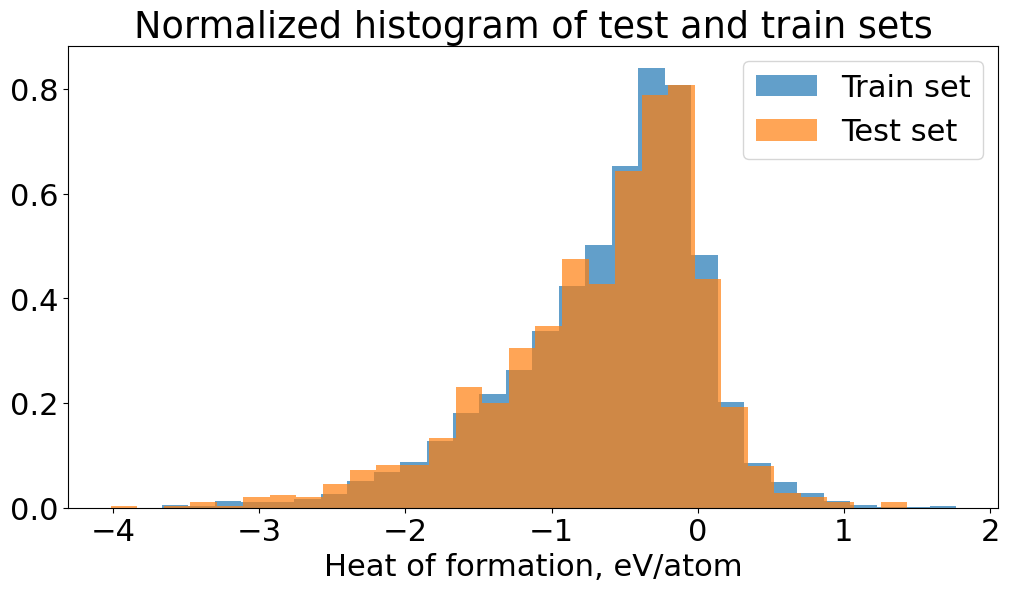

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=251)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()


# Sklearn Linear Regression model

In [22]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [25]:
n_comp_PCA = 1

pca = PCA(n_components = n_comp_PCA).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print("With {} PCA components {var:0.4f}% of the variance is explained".format(n_comp_PCA, var = 100*np.sum(pca.explained_variance_ratio_)))
print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))

With 1 PCA components 62.6958% of the variance is explained
X_train: (6400, 1)
X_test: (1600, 1)


In [15]:
model = LinearRegression()
model.fit(X=X_train,y=y_train)

LinearRegression()

In [16]:
train_prediction = model.predict(X_train)
train_prediction

array([-0.70051874, -0.56113019, -0.69268714, ..., -0.69816129,
       -0.65002079, -0.63147501])

In [17]:
test_prediction = model.predict(X_test)
test_prediction

array([-0.70196184, -0.7024337 , -0.66178103, ..., -0.72777871,
       -0.65236335, -0.67732851])

In [18]:
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 0.65
Test RMSE = 0.69


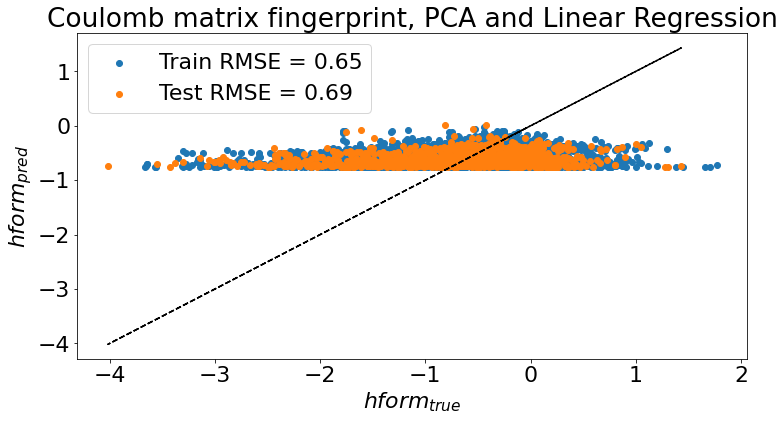

In [19]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint, PCA and Linear Regression")
plt.scatter(y_train, model.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, model.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$hform_{true}$")
plt.ylabel("$hform_{pred}$")
plt.legend()
plt.show()

Doesn't look good. Is it even better than predicting the average value?

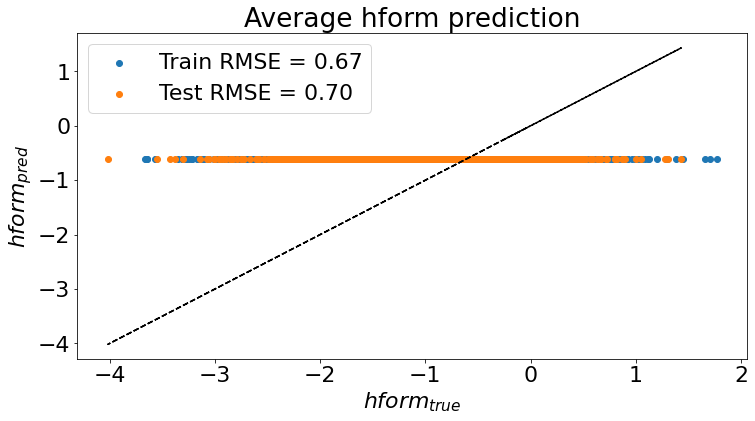

In [20]:
fig = plt.figure(figsize = (12, 6))

train_avg_pred = [y_train.mean()]*len(y_train)
test_avg_pred = [y_train.mean()]*len(y_test)

plt.title("Average hform prediction")
plt.scatter(y_train, train_avg_pred, label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_avg_pred)))
plt.scatter(y_test, test_avg_pred, label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_avg_pred)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$hform_{true}$")
plt.ylabel("$hform_{pred}$")
plt.legend()
plt.show()

# Prepare submission to Kaggle

In [21]:
cmats_test = np.zeros((len(test),max_number_of_atoms**2))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmats_test[i,:] = cm.create(atoms)
print(len(cmats_test))

0
1000
2000
3000
4000


In [22]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.id)
X_test_kaggle = pca.transform(X_test_kaggle)

Y_test_kaggle = model.predict(X_test_kaggle)
Y_test_kaggle

array([-0.60369639, -0.52216352, -0.46226478, ..., -0.63049356,
       -0.75659381, -0.6374141 ])

In [23]:
test_prediction_dataframe = pd.DataFrame(data = {'id':test.id,
                                                 'hform':Y_test_kaggle})
test_prediction_dataframe.head(n=20)

,id,hform
0,8538,-0.603696
1,9052,-0.522164
2,10503,-0.462265
3,611,-0.400919
4,7212,-0.705495
5,10750,-0.483531
6,1646,-0.709309
7,6893,-0.653508
8,4403,-0.736024
9,1641,-0.709091


In [24]:
test_prediction_dataframe.to_csv(data_dir+'submission_test.csv',index=False)

## Installing Dscribe on Windows

If you tried to install Dscribe from pip you most likely got an error message about not having Microsoft Visual C++ installed. It might not be the easiest way to get it to work but it is possible to get a working install of Dscribe on Windows by doing the following:

- Install Microsoft Visual Studio
 - Under Windows, there are 3 choices. Only check Desktop development with C++
 - Under Web & Cloud, there are 7 choices. Only check Python development

- Create a new environment in anaconda
 - Open the Anaconda prompt
 - conda create -n yourenvname python=3.7 
 - conda activate yourenvname

- Install pip and git in the new environment
 - conda install -n yourenvname pip git
 
- Install Dscribe directly from Github
 - pip install git+https://github.com/SINGROUP/dscribe
 
Hopefully, this will make it work.

In case you still have problems with Dscribe on Windows (and you want to experiment with SOAP) and you don't have a Mac/Linux friend in your group or maybe even one of the competing groups, then please send me an email (pmely@dtu.dk) and we can figure something out.

## Installing Dscribe on M1 Mac
M1 Macs needs the Python packages to be compiled for the osx-arm64 architecture. This can couse problems when installing packages from pip. 

- Create a new environment in anaconda
 - Open the terminal
 - conda create -n yourenvname python=3.8
 - conda activate yourenvname

- Install pip and git in the new environment
 - conda install -n yourenvname pip git
 
- Try to install Dscribe directly from Github
 - pip install git+https://github.com/SINGROUP/dscribe
 
- You will likely get an error that some of the dependencies packages cannot be installed. Install these packages seperately from conda-forge:
 - conda install -c conda-forge 'PACKAGE_NAME'
 
Again, if you still have problems with Dscribe on Windows (and you want to experiment with SOAP) and you don't have a Mac/Linux friend in your group or maybe even one of the competing groups, then please send me an email (pmely@dtu.dk) and we can figure something out.
 
## Alternative: Google Colab

If all other fails, then you can use Google Colab - either just to create the fingerprints and use "pickle" to download them, so you can do the machine learning locally on your own computer. Or you can do the whole project on Colab.

To install packages on Google Colab use "!pip". E.g. install Dscribe by running the following command in the Colab notebook:
- !pip install dscribe

You will have to install Dscribe each session and it will take a few minutes.
